# Stable Diffusion
So far we have been taking advantage of HuggingFaces [StableDiffusionPipeline](https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion/text2img) in order to  perform txt2img inference. We have also been using HFs accelerate library and their example [fine tuning scripts](https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/train_text_to_image.py) to fine tune pretrained SD models on our own datasets.

The StableDiffusionPipeline to run txt2img requires 7 different parameters in order to operate:

- vae (AutoencoderKL) — Variational Auto-Encoder (VAE) model to encode and decode images to and from latent representations.
- text_encoder (CLIPTextModel) — Frozen text-encoder (clip-vit-large-patch14).
- tokenizer (CLIPTokenizer) — A CLIPTokenizer to tokenize text.
- unet (UNet2DConditionModel) — A UNet2DConditionModel to denoise the encoded image latents.
- scheduler (SchedulerMixin) — A scheduler to be used in combination with unet to denoise the encoded image latents. Can be one of DDIMScheduler, LMSDiscreteScheduler, or PNDMScheduler.
- safety_checker (StableDiffusionSafetyChecker) — Classification module that estimates whether generated images could be considered offensive or harmful. Please refer to the model card for more details about a model’s potential harms.
- feature_extractor (CLIPImageProcessor) — A CLIPImageProcessor to extract features from generated images; used as inputs to the safety_checker.

In this demo we will explore one of these components in detail - The UNet architecture.

## UNet Architecture

The UNet Diffusion architecture has revolutionized the way in which image generation is orchestrated. The UNet architecture was first introduced in the paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf). In this paper Ronneberger, et al. were investigating methods for generating accurate image segmentation in a biomedical context. This model was a great success and since its release in 2015 the UNet has been shown incredible performance in many image related tasks.

In this notebook we are going to take a deep dive into this paper, exploring the details of the architecture. Next, we will implement a basic UNet architecture using PyTorch. For this task we will utilize a predefined dataset from HuggingFace - "segments/sidewalk-semantic" - which will train a model to segment a scene as viewd by a robot moving on a sidewalk. This toy example will serve as a foundation for exploring further the nature of computer vision.

### U-Net: Convolutional Networks for Biomedical Image Segmentation by Olaf Ronneberger, Philipp Fischer, and Thomas Brox
#### Introduction

Motivation: At the time convolution neural networks (CNN) made significant breakthroughs in image classification. In particular thanks to the work of Krizhevsky, et al. who performed supervised training of a large network with millions of parameters trained on ImageNet - a dataset with 1 million training images. These models demonstrated excellent results with respect ot single label classification tasks but fall short when used on other, more compelx visual tasks. In particular solving problems within biomedicla image processing, the desired output should include localization, ie.e a class label is supposed to be assigned to each pixel. An furthermore thousands of training images are usually beyond the reach in these tasks. 

It was demonstrated by [Ciresan et al.](https://arxiv.org/pdf/1202.2745.pdf) that it is possible to train a network with a sliding-window setup to predict the class label of each pixel by providing a local region (patch) around that pixel. This network can localize (classify on a pixel by pixel basis) and due to the use of these patches the dataset becomes much larger. Ronneberger, et al. discuss two specific drawbacks to Ciresan et al.'s work. First the claim it is slow because the entwork must be run separately for each patch, and there is a lot of redundancy due to overlapping patches. Second, there is a trade-off between localization accuracy and the use of co0ntext. Larger patches require more max-pooling layers that reduce the localization accuracy, while small patches allow the network to see only little context.

In this paper they propose a more elegant architecture - the "fully convolutional network". They claim this architecture works with very few training images and yields more precise segmentations. The authors state that one important modification in their architecture is that in the upsampling part they have a larger number of feature channels which allow the network to propogate context information to higher resolution layers. As a consequence, the expansive path ios more or less symetric to the contracting path and yields a u-shaped architecture (Fig. 1) 

<img src="./assets/fig1.png" width="900" />


This sentence leaves me a bit confused - perhaps it will be better understood with implementation context: "To predict the pixels in the border region of the image, the missing context is extrapolated by mirroring the input image."

The team speaks about the challenge of segmentation with respect to touching-objects (like cells). The team proposes the use of a weighted loss, where the separating background labels between touching cells obtain a large weight in the loss function.

#### Network Architecture

Fig. 1 demonstrate the network architecture. It consists of a contracting path and an expansive path. The input image starts as a single channel 572x572 image. This image is considered to have 1 "feature" (the single color channel), in this first block the image each pixel is embedded from this feature space of one to a 64 dimensioned feature space. This transformation into a higher dimension of feature space allows the network to capture hierarchical information from the input image. The contracting path consists of the repeated application of two 3x3 convolutions (unpadded), each followed by a ReLU unit and a 2x2 max pooling operation with stride 2 for downsampling. At each downsampling step the number of feature channels are doubled. This continues until the network passes through a bottleneck, after which the expansion path begins.  Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 convolution ("up-convolution") that halves the feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU. The paper then talks about the cropping that occurs in these expansion stages. They say that it is necessary due to "the loss of border pixels in every convolution." At ther final layer a 1x1 convolution is used to map each 64 component feature vectors to the desired number of classes. In total the network has 23 convolutional layers.

#### Training

The authors begin the training section by addressing several aspects to the run. First they state that they are using input images and their corresponding segmentation maps to train the network using stochastic gradient descent. This process will use unpadded convolutions, so the output images will have a smaller pixel width and height. Additionally, to maximize use of the GPU memory, they favor large input tiles over a large batch size - hence reduce the batch to a single image. A high momentum is used (0.99) 

"The energy function is computed by a pixrel-wise soft-mac over the final feature map combined with the cross entropy loss function." When they speak of the energy function, they also mean the loss function. So each output pixel feature map with be passed through a soft-max function and then the cross entropy loss function. The softmax gives a probability distribution for the value that that pixel might be and cross entropy loss is used to compute the loss between the true probability distribution against the predicted.

#### Softmax Function
For an input vector \( z = [z_1, z_2, ..., z_n] \), the softmax function for each element \( z_i \) is:
$$
\sigma(z)_i = \frac{e^{z_i}}{\sum_{j=1}^{n} e^{z_j}}
$$

#### Cross Entropy Loss
Given a true distribution \( y \) and a predicted distribution \( \hat{y} \), the cross entropy loss is:
$$
L(y, \hat{y}) = -\sum_{i} y_i \log(\hat{y}_i)
$$

#### Weight Map
The authors speak about pre-computing a weight map for each ground truth segmentation "to compoensate the different frequency of pixels from a certian class in the training data set, and to force the network to learn the small seperation borders that we introduce between touching cells"

This seperation border is computed usig a "morphological operation"
$$ w(x) = w_c(x) + w_0 \cdot \exp\left( -\frac{(d_1(x) + d_2(x))^2}{2\sigma^2} \right) $$

I'm not to sure about this section. I think I will have to refer back here when I am building the network for reference.

The authors emphasis that in CNN with many layers and different paths through the network, a good intialization is extremely important. Intial weights are drawn from a Gaussian distribution with a standard deviation of $\sqrt{\frac{2}{N}}$, where $N$ denotes the number of incoming ndoes of one neuron. For a 3x3 convolution and 64 feature channels in the previous layer N = 9*64 = 576

### Data Augmentation

Data augmentation was used in this paper to increase robustness and variance of the dataset. Image shifts, rotations, deformations, and gray value variation was employed to augment the dataset. They also emphasis the use of random elastic deformations of the training samples. This transformation was key to train a segmentation network with very few annotated images. The input images are all 512x512 pixels and gray scale.

###  Conclusion

They researchers found that their technique performed exceptionally well at biomedical segmentation tasks, outperforming all the competing models available at the time.

Now it's time to try and build our own

## Our UNet

For our UNet we will implement a Segmentation UNet of brain tumor in MRI images. We will be utilizing material from PyTorch and kaggle to accomplish this task.

Here are links to some essential resources:
- [U-NET FOR BRAIN MRI - PYTORCH RESOURCES](https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/)
- [BRAIN MRI SEGMENTATION - KAGGLE](https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation)
- [Association of genomic subtypes of lower-grade gliomas with shape features automatically extracted by a deep learning algorithm](https://arxiv.org/pdf/1906.03720.pdf)
- [MATEUSZ'S GITHUB](https://github.com/mateuszbuda/brain-segmentation-pytorch/tree/master)

### Acknowledgements
Thanks to [milesial](https://github.com/milesial/Pytorch-UNet). Their work was very helpful. The prior to viewing their work I did not know what nn.Upsample was. Not only that, their style and organization motivated me to learn more about logging and docker.

In [1]:
# imports
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torch.functional as F
import pandas as pd
import os
import shutil
import random
import csv
from PIL import Image

In [2]:
# Let's first of all set up the device we will be using to train this model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

## Create the Dataset
The first step in building a UNet segmentation model is to construct out dataset. For this example we are using MRI brain scans and their associated segmentation mask which identifies the presence of possible tumors. 

We begin by downloading the dataset available from Mateusz Buda on Kaggle, which can be found - [here](https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation).

We will create a custom dataset using PyTorchs [dataset and dataloader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) classes.

#### Download the Data

 First we have to take what we downloaded from Kaggle and organize it in a way so that we can easily access and manipulate the data comes in a compressed file called 'archive.zip'. Extract this bad boy into our UNet working directoy. We see that there are two folders, one that says kaggle_3m/ which contains individual patient brain MRI slices and their correspond segmentation masks. It appears that the other folder, lgg-mri-segmentation/ contains the same data. I'm not really sure what this is about, the README documentation associated with the data does not mention this, in fact it is the same README in both folders.

 So what is most important for us in this task is to take these pairs and turn them into image, mask pairs that can be accessed using the dataset library from PyTorch.

In [3]:
# The data we downloaded from Kaggle seems redundant. 
# Using this script to verify if at least the data.csv files are identical
# If they are I am going to delete one of the folders to eliminate this redundancy.
"""

def csvs_are_identical(file1, file2):
    with open(file1, 'r') as f1, open(file2, 'r') as f2:
        reader1 = csv.reader(f1)
        reader2 = csv.reader(f2)

        for row1, row2 in zip(reader1, reader2):
            if row1 != row2:
                return False

        # Check if one file is longer than the other
        return next(reader1, None) is None and next(reader2, None) is None

file1_path = './archive/kaggle_3m/data.csv'
file2_path = './archive/lgg-mri-segmentation/kaggle_3m/data.csv'

if csvs_are_identical(file1_path, file2_path):
    print("The CSV files are identical.")
else:
    print("The CSV files are different.")
"""

'\n\ndef csvs_are_identical(file1, file2):\n    with open(file1, \'r\') as f1, open(file2, \'r\') as f2:\n        reader1 = csv.reader(f1)\n        reader2 = csv.reader(f2)\n\n        for row1, row2 in zip(reader1, reader2):\n            if row1 != row2:\n                return False\n\n        # Check if one file is longer than the other\n        return next(reader1, None) is None and next(reader2, None) is None\n\nfile1_path = \'./archive/kaggle_3m/data.csv\'\nfile2_path = \'./archive/lgg-mri-segmentation/kaggle_3m/data.csv\'\n\nif csvs_are_identical(file1_path, file2_path):\n    print("The CSV files are identical.")\nelse:\n    print("The CSV files are different.")\n'

In [4]:
# So we want to take each tif in the data rename each as img{i}.tif or mask{i}.tif where i is a count
# For our specific use case we do not need to maintain cohesion between patient, specific MRI slice, and the image.
# We just want to train the model to segment a specific image in isolation.

# Let's grab each file and rename it and store it in ./temp/ before splitting the data into train, test, and val folders.

# Uncomment the lines below to run cell if you have not fixed file names
"""
source_dir = "./archive/kaggle_3m/" # All the tifs are stored in directories that start with this path


for subdir, _ , files in os.walk(source_dir):
    if subdir != source_dir:
        for i, file in enumerate(files):
            src_file_path = os.path.join(subdir, file)
            prefix = subdir.split('/')[-1]
            new_file_name = file.replace(prefix+"_", "")
            dst_file_path = os.path.join(subdir, new_file_name)
            os.rename(src_file_path, dst_file_path)
"""

'\nsource_dir = "./archive/kaggle_3m/" # All the tifs are stored in directories that start with this path\n\n\nfor subdir, _ , files in os.walk(source_dir):\n    if subdir != source_dir:\n        for i, file in enumerate(files):\n            src_file_path = os.path.join(subdir, file)\n            prefix = subdir.split(\'/\')[-1]\n            new_file_name = file.replace(prefix+"_", "")\n            dst_file_path = os.path.join(subdir, new_file_name)\n            os.rename(src_file_path, dst_file_path)\n'

In [5]:
# Now that the files are renamed lets go back through the directories, copy each to temp and rename
# Uncomment line below if you have not copied files to tmp
"""
count = 0
dst_dir = "./tmp/"
for subdir, _, files in os.walk(source_dir):
    if subdir != source_dir:
        for value in range(1,int(len(files)/2)+1):
            for file in files:
                file_num = int(file.split("_")[0].split(".")[0])
                if file_num == value:
                    src_file_path = os.path.join(subdir, file)
                    if "mask" in file:
                        dst_file_path = os.path.join(dst_dir, str(file_num+count)+"_mask.tif")
                    else:
                        dst_file_path = os.path.join(dst_dir, str(file_num+count)+".tif")  
                    shutil.copy(src_file_path, dst_file_path)
        count += int(len(files)/2)
"""

'\ncount = 0\ndst_dir = "./tmp/"\nfor subdir, _, files in os.walk(source_dir):\n    if subdir != source_dir:\n        for value in range(1,int(len(files)/2)+1):\n            for file in files:\n                file_num = int(file.split("_")[0].split(".")[0])\n                if file_num == value:\n                    src_file_path = os.path.join(subdir, file)\n                    if "mask" in file:\n                        dst_file_path = os.path.join(dst_dir, str(file_num+count)+"_mask.tif")\n                    else:\n                        dst_file_path = os.path.join(dst_dir, str(file_num+count)+".tif")  \n                    shutil.copy(src_file_path, dst_file_path)\n        count += int(len(files)/2)\n'

In [6]:
# Alright so we have just moved the newly named files into a tmp directory
# Next we need to split these up into train/test data sets in the img directory
# To do this we need to decide on a split. Let's do 80/20 and we want to do it randomly

# Uncomment if you have not run already
"""

# Find out how many image/mask pairs there are in our dataset
source_dir = "./tmp/"
files = next(iter(os.walk(source_dir)))[-1]
num_pairs = int(len(files)/2)

# Now we want to make a list of values from 1 to num_pairs in using random.sample
numbers = list(range(1, num_pairs+1))
random_sample = random.sample(numbers, len(numbers))

# Let's split the imgs and move them to their appropriate directories!
split = int(.8*num_pairs)

train_split = []
test_split = []

for i, sample in enumerate(random_sample):
    for j, file in enumerate(files):
        file_num = int(file.split("_")[0].split(".")[0])
        if file_num == sample: # If true we place this file into test
            if "mask" in file:
                mask = file
            else:
                img = file
    img_pair = (img, mask)
    if i < split:
        shutil.copy2(source_dir+img_pair[0], "./img/train/"+img_pair[0])
        shutil.copy2(source_dir+img_pair[1], "./img/train/"+img_pair[1])
        train_split.append(img_pair)
    else:
        shutil.copy2(source_dir+img_pair[0], "./img/test/"+img_pair[0])
        shutil.copy2(source_dir+img_pair[1], "./img/test/"+img_pair[1])
        test_split.append(img_pair)

train_csv = "./img/train/train.csv"
test_csv = "./img/test/test.csv"

with open(train_csv, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["image", "mask"])
    writer.writerows(train_split)

with open(test_csv, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["image", "mask"])
    writer.writerows(test_split)
"""

'\n\n# Find out how many image/mask pairs there are in our dataset\nsource_dir = "./tmp/"\nfiles = next(iter(os.walk(source_dir)))[-1]\nnum_pairs = int(len(files)/2)\n\n# Now we want to make a list of values from 1 to num_pairs in using random.sample\nnumbers = list(range(1, num_pairs+1))\nrandom_sample = random.sample(numbers, len(numbers))\n\n# Let\'s split the imgs and move them to their appropriate directories!\nsplit = int(.8*num_pairs)\n\ntrain_split = []\ntest_split = []\n\nfor i, sample in enumerate(random_sample):\n    for j, file in enumerate(files):\n        file_num = int(file.split("_")[0].split(".")[0])\n        if file_num == sample: # If true we place this file into test\n            if "mask" in file:\n                mask = file\n            else:\n                img = file\n    img_pair = (img, mask)\n    if i < split:\n        shutil.copy2(source_dir+img_pair[0], "./img/train/"+img_pair[0])\n        shutil.copy2(source_dir+img_pair[1], "./img/train/"+img_pair[1])\n

The above code is definitely not the most efficient way. If the image dataset was larger this process would not work. For the purposes of this demo, this will have to do. Feel free to experiment with faster algorithms!

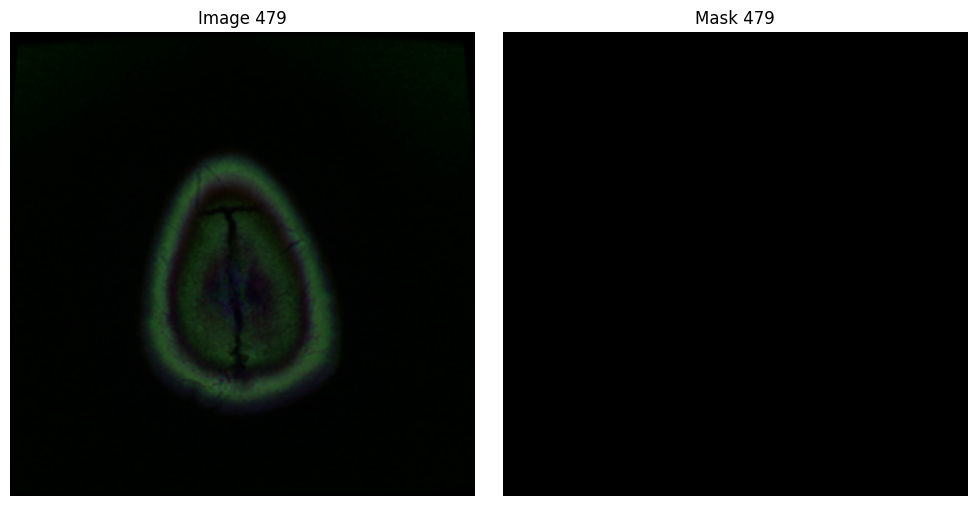

In [7]:
# Now we need to create our own custom dataset

class ImgSegDataset(Dataset):
    def __init__(self, image_dir, annotations_file, transform=None, target_transform=None):
        super().__init__()
        self.img_dir = image_dir
        self.img_mask_pair = pd.read_csv(annotations_file)
        self.transform = transform 
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.img_mask_pair)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_mask_pair.iloc[idx, 0])
        image = Image.open(img_path)
        mask_path = os.path.join(self.img_dir, self.img_mask_pair.iloc[idx, 1])
        mask = Image.open(mask_path)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)
        return image, mask

# Build our Train and Test datasets!
train_dir = "./img/train/"
test_dir = "./img/test/"
train_annotations_file = os.path.join(train_dir, "train.csv")
test_annotations_file = os.path.join(test_dir, "test.csv")

transform = transforms.Compose([
    transforms.Resize((572,572)),
    transforms.ToTensor()])

target_transform = transforms.Compose([
    transforms.Resize((388,388)),
    transforms.ToTensor()])

train_dataset = ImgSegDataset(train_dir, train_annotations_file, transform=transform, target_transform=target_transform)
test_dataset = ImgSegDataset(test_dir, test_annotations_file, transform=transform, target_transform=target_transform)

# Let's take a look! Plot a random image and mask
rand_idx = random.randint(0, len(train_dataset))
img = train_dataset[rand_idx][0].permute(1,2,0)
mask = train_dataset[rand_idx][1].permute(1,2,0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.imshow(img)
ax1.axis('off')
ax1.set_title(f'Image {rand_idx}')

ax2.imshow(mask, cmap="gray")
ax2.axis('off')
ax2.set_title(f'Mask {rand_idx}')

plt.tight_layout()
plt.show()




In [8]:
# Now let's turn them into DataLoaders
# Set batch_size
BS = 1

train_dl = DataLoader(train_dataset, batch_size=BS, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=BS, shuffle=True)
"""
# Try it out
img, mask = next(iter(train_dl))
img = img.squeeze()
img = img.permute(1,2,0)
mask = mask.squeeze()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.imshow(img)
ax1.axis('off')
ax1.set_title(f'Image')

ax2.imshow(mask, cmap="gray")
ax2.axis('off')
ax2.set_title(f'Mask')

plt.tight_layout()
plt.show()
"""

'\n# Try it out\nimg, mask = next(iter(train_dl))\nimg = img.squeeze()\nimg = img.permute(1,2,0)\nmask = mask.squeeze()\nfig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))\n\nax1.imshow(img)\nax1.axis(\'off\')\nax1.set_title(f\'Image\')\n\nax2.imshow(mask, cmap="gray")\nax2.axis(\'off\')\nax2.set_title(f\'Mask\')\n\nplt.tight_layout()\nplt.show()\n'

## Build the Network!

In [25]:

# DoubleConv is the double convolution that occurs at each stage in the UNet
class DoubleConv(nn.Module):
    """
    DoubleConv is used at each layer of the UNet.
    This class will perform: (conv -> batchnorm -> ReLu) * 2
    This can be used by itself (like in the very first layer.
    Or it will be used in conjuction with a nn.MaxPool2d or nn.Upsample
    to build the consecutive layers of the UNet)

    nn.BatchNorm2d - https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html
    """
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels=out_channels
        self.doubleconv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=0),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels,out_channels, kernel_size=3, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.doubleconv(x)


# DownSamp will conduct the max pooling on the previous layer to downsample it towards the bottleneck
class DownSamp(nn.Module):
    """
    MaxPools the previous layer to downsample and then performs a DoubleConv
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.downsamp = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    
    def forward(self, x):
        return self.downsamp(x)


# UpSamp will conduct the upsampling from the bottleneck towards the network output
class UpSamp(nn.Module):
    """
    Will nn.Upsample the previous layer and then perform a DoubleConv.
    The forward pass will also include the skip connections from the downsampled
    layers. Performing a crop and concatenation.

    This process of using skip connections allows the network to preserve high-level
    abstract features that were tuned in the downsampling pathway. By merging 
    information from different scales, the features captured at different layers can 
    complement each other.

    For this implementation we are using nn.Upsample in bilinear mode to do the upsampling.
    See docs for more info - https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upconv = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1))
        self.doubleconv = DoubleConv(in_channels, out_channels)
        
    def forward(self, x1, x2):
        # x1 is the previous layers output, x2 is the skip connection
        # from the corresponding downsample layer

        # First upsample the incoming data
        x1 = self.upconv(x1)

        # Once the previous layer is upsampled we need to crop and concatenate 
        # the skip connection from the corresponding downsample layer.
        # Since this cropping will be different for each layer we must find the dimension differences
        desired_size = tuple(x1.size()[2:])
        current_size = x2.size()[2:]

        # Calculate the cropping dimensions for both sides
        crop_dims = [(cur_size - des_size) // 2 for cur_size, des_size in zip(current_size, desired_size)]
        # Perform cropping symmetrically from all sides
        x2 = x2[:, :, crop_dims[0]:current_size[0]-crop_dims[0], crop_dims[1]:current_size[1]-crop_dims[1]]

        x = torch.cat([x1, x2], dim=1)
        
        return self.doubleconv(x)
    
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        return self.conv(x)

Orginal Shape: torch.Size([1, 3, 572, 572])
conv_block Shape: torch.Size([1, 64, 568, 568])
down_block1 Shape: torch.Size([1, 128, 280, 280])
down_block2 Shape: torch.Size([1, 256, 136, 136])
down_block3 Shape: torch.Size([1, 512, 64, 64])
down_block4 Shape: torch.Size([1, 1024, 28, 28])
up_block1 Shape: torch.Size([1, 512, 52, 52])
up_block2 Shape: torch.Size([1, 256, 100, 100])
up_block3 Shape: torch.Size([1, 128, 196, 196])
up_block4 Shape: torch.Size([1, 64, 388, 388])
out shape: torch.Size([1, 1, 388, 388])


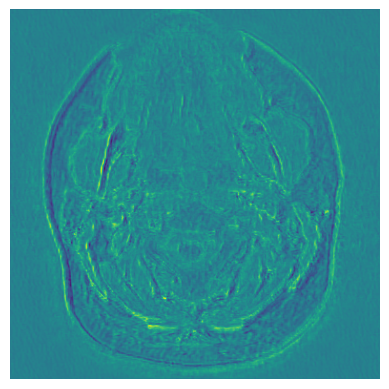

In [36]:
# At this stage I wanted to test my nn.Module classes, make sure that they were performing the
# correct matrix operations and track their shape through the network.
# I also spent some time trying to figure out how to get this bad boy on cuda but I wasn't
# successful... will have to try later maybe? 

conv_block1 = DoubleConv(in_channels=3, out_channels=64)
down_block1 = DownSamp(in_channels=64, out_channels=128)
down_block2 = DownSamp(in_channels=128, out_channels=256)
down_block3 = DownSamp(in_channels=256, out_channels=512)
down_block4 = DownSamp(in_channels=512, out_channels=1024)
up_block1 = UpSamp(in_channels=1024, out_channels=512)
up_block2 = UpSamp(in_channels=512, out_channels=256)
up_block3 = UpSamp(in_channels=256, out_channels=128)
up_block4 = UpSamp(in_channels=128, out_channels=64)
outconv = OutConv(in_channels=64, out_channels=1)


X, _ = next(iter(train_dl))


print(f"Orginal Shape: {X.shape}")
X1 = conv_block1(X)
print(f"conv_block Shape: {X1.shape}")
X2 = down_block1(X1)
print(f"down_block1 Shape: {X2.shape}")
X3 = down_block2(X2)
print(f"down_block2 Shape: {X3.shape}")
X4 = down_block3(X3)
print(f"down_block3 Shape: {X4.shape}")
X5 = down_block4(X4)
print(f"down_block4 Shape: {X5.shape}")
X6 = up_block1(X5, X4)
print(f"up_block1 Shape: {X6.shape}")
X7 = up_block2(X6, X3)
print(f"up_block2 Shape: {X7.shape}")
X8 = up_block3(X7, X2)
print(f"up_block3 Shape: {X8.shape}")
X9 = up_block4(X8, X1)
print(f"up_block4 Shape: {X9.shape}")
out = outconv(X9)
print(f"out shape: {out.shape}")

out = out[0].squeeze()
plt.axis("off")
plt.imshow(out.detach().numpy());


